# Supervised Time Series Analysis

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset

import optuna
from utils import Loader

from dataclasses import dataclass

from typing import Union, List, Tuple, Optional
import time, os
from datetime import datetime, timedelta

sns.set_style("dark")
# device = torch.device('mps')

# Anomaly Detection Code

In [3]:
@dataclass
class MethodConfig:
    dataset_name: str
    column_name: str
    threshold: float
    block_size: int
    model_type: str
    target_date: str

In [4]:
class LSTM(nn.Module):
    def __init__(self, config):
        super(LSTM, self).__init__()
        self.config = config
        self.hidden_dim = config.hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(1, self.hidden_dim, num_layers=config.n_layers, batch_first=True) # (B, T, C)

        # The linear layer that maps from hidden state space to tag space
        self.fc1 = nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x[:, -1, :])
        return x

In [5]:
class LoadModel:
    def __init__(self, input_config:MethodConfig):
        self.config = input_config
        self.dataset_name, self.column_name  = input_config.dataset_name, input_config.column_name
        self.files = {
            "co2-1":'data/co2-1.csv',
            "co2-2":'data/co2-2.csv',
            "ele-1":'data/ele-1.csv',
            "ele-2":'data/ele-2.csv',
        }

    def _batch_data_steps(self, input_array:np.ndarray) -> tuple[np.ndarray,np.ndarray]:
        X = [input_array[i: i+self.config.block_size] for i in range(len(input_array)-self.config.block_size)]
        Y = [input_array[i + self.config.block_size] for i in range(len(input_array)-self.config.block_size)]
        return np.array(X).reshape(len(X),-1), np.array(Y)

    def _get_xgb_data(self):
        self.raw_df = pd.read_csv(self.files[self.dataset_name])
        self.raw_df["time"] = pd.to_datetime(self.raw_df["time"])  # Convert "time" column to datetime
        self.raw_df.set_index("time", inplace=True)  # Set "time" as the index
        self.raw_df = self.raw_df[self.column_name].to_frame()

        self.scaler = StandardScaler()
        arr = self.scaler.fit_transform(self.raw_df[self.column_name].values.reshape(-1,1)) # type: ignore
        return self._batch_data_steps(arr)

    def _parse_model_file_name(self) -> str:
        files = os.listdir("models/")
        for file in files:
            if self.dataset_name in file and self.column_name in file:
                return "models/" + file
        return f"Could not find model {self.dataset_name}_{self.column_name}"
    
    def get_specified_model(self, model_type:str):
        if model_type == "LSMT":
            file_path_to_model = self._parse_model_file_name()
            try:
                return torch.load(file_path_to_model)
            except Exception:
                raise Exception(f"Not able to get specified model: {file_path_to_model}")
        elif model_type == "GBT":
            X,Y = self._get_xgb_data()
            MODEL = XGBRegressor(n_estimators=300, max_depth=5, subsample=0.5681930635231892)
            MODEL.fit(X, Y)
            return MODEL
        else:
            raise Exception(f'get_specified_model failed for {model_type}')
    

In [6]:
class DateParser:
    """
    Logic to return dataframe index of specified data range
    """
    def setup(self, target_date:str, column_name:str) -> None:
        self.column_name = column_name
        self.target_date = target_date + " 0:00:00"
        self.start_date = datetime.strptime(self.target_date, '%Y-%m-%d %H:%M:%S')
    
    def _check_df_for_date(self, input_date) -> bool:
        date = input_date
        try:
            if isinstance(self.df.loc[date], pd.Series):
                return True
            else: return False
        except KeyError:
            return False

    def _define_time_delta(self) -> dict:
        td = dict()
        if self.column_name in ['zone_022_co2', 'zone_052_co2', 'zone_072_co2']:
            # Per minute steps
            td = {"days":timedelta(days=7), "offset":timedelta(minutes=1)}
        else:
            # Per 15 min time steps for ele reading
            td = {"days":timedelta(days=7), "offset":timedelta(minutes=15)}
        return td

    def _calculate_date_range_rows(self, input_df):
        self.df = input_df

        if self._check_df_for_date(self.start_date):
            # print(f'debugging : start date in dataset {self.start_date}')
            td = self._define_time_delta()
            self.end_date = (self.start_date + td["days"]) - td["offset"]
            self.end_date = self.end_date.strftime('%Y-%m-%d %H:%M:%S')
            
            if self._check_df_for_date(self.end_date):
                # print(f'debugging : end date in dataset {self.end_date}')
                rowStart = self.df.index.get_loc(self.start_date) 
                rowEnd = self.df.index.get_loc(self.end_date)

            else:
                raise Exception(f'{self.end_date} not in dataset {self.column_name}')
        
        else:
            raise Exception(f'{self.start_date} not in dataset {self.column_name}')
        
        return rowStart, rowEnd + 1
        
    def get_date_range_index(self, input_config:MethodConfig, input_df:pd.DataFrame)-> Tuple[int, int]:
        self.setup(input_config.target_date, input_config.column_name)
        res = self._calculate_date_range_rows(input_df)
        print(f'debugging get_date_range_index | found start date {self.start_date} and end date {self.end_date} in {self.column_name}')
        return res

class TimeSeriesDetect:
    def __init__(self) -> None:
        self.files = {
            "co2-1":'data/co2-1.csv',
            "co2-2":'data/co2-2.csv',
            "ele-1":'data/ele-1.csv',
            "ele-2":'data/ele-2.csv',
        }

    def _load_data(self, dataset_name:str, column_name:str) -> pd.DataFrame:
        raw_df = pd.read_csv(self.files[dataset_name])
        raw_df["time"] = pd.to_datetime(raw_df["time"])  # Convert "time" column to datetime
        raw_df.set_index("time", inplace=True)  # Set "time" as the index

        df = raw_df[column_name].to_frame()

        self.scaler = StandardScaler()
        df["scaled_"+column_name] = self.scaler.fit_transform(df[[column_name]])

        return df
    
    def calculate_date_range_index(self) -> Tuple[int, int]:
        return DateParser().get_date_range_index(self.cfg, self.df)

    def structured_time_series_data(self) -> np.ndarray:
        """
        Load data and carefully batch time series into block_size per trained model 
        """
        self.df = self._load_data(self.cfg.dataset_name, self.cfg.column_name)
        vals = self.df["scaled_" + self.cfg.column_name].values
        return np.array([vals[i: i+self.cfg.block_size] for i in range(len(vals)-self.cfg.block_size)])

    def make_predictions(self, input_config:MethodConfig):
        self.cfg = input_config
        st = time.perf_counter()
        print(f'\nStarted Detection of {self.cfg.dataset_name}_{self.cfg.column_name} with {self.cfg.model_type}')
        
        L = LoadModel(input_config)
        self.MODEL = L.get_specified_model(input_config.model_type)
        
        # Set up prediction range
        inputs_index = self.structured_time_series_data()
        results_index = np.zeros(self.df.shape[0])
        s, e = self.calculate_date_range_index()

        # Main prediction loop
        for i in range(s, e):
            X = inputs_index[i]
            if input_config.model_type == "LSMT":
                y_pred = self.MODEL(torch.tensor(X.reshape(1, self.cfg.block_size, 1), dtype=torch.float32)).item()
            else:
                y_pred = self.MODEL.predict(X.reshape(1, X.shape[0]))[0]
            results_index[i + self.cfg.block_size] = y_pred

        # Invert standard scaler
        self.df["scaled_pred"] = results_index
        scaled_pred_vals = self.df["scaled_pred"].values.reshape(results_index.shape[0], 1)
        self.df["pred"] = self.scaler.inverse_transform(scaled_pred_vals)

        # Drop time range points that were not predicted
        res_df = self.df[self.df["scaled_pred"]!= 0.0].copy()

        # Calculate anomalies by MAPE
        # res_df["mape"] = abs(res_df[self.cfg.column_name] - res_df["pred"]) / res_df[self.cfg.column_name]
        # res_df["anomaly"] = res_df["mape"] > self.cfg.threshold

        # Calculate anomalies by MAE
        res_df["mae"] = abs(res_df[self.cfg.column_name] - res_df["pred"])
        res_df["anomaly"] = res_df["mae"] > self.cfg.threshold

        # Summarize evaluation
        err:int = res_df[res_df["anomaly"]].shape[0]
        print(f'Completed scan of {res_df.shape[0]} points in {time.perf_counter()-st:.1f} secs | Anomalies Counted: {err}')
        return res_df
    
    def plot_anomaly_results_on_axis(self, input_df:pd.DataFrame, model_type:str='model', ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(13, 6))

        column_name = TimeSeriesDetect.get_correct_column(input_df)

        # Overlay points where outlier is True
        anomaly_points = input_df[input_df['anomaly']]
        sns.scatterplot(x=anomaly_points.index, y=anomaly_points[column_name], color='red', ax=ax, s=40, zorder=100)

        # Plot the original time series
        sns.lineplot(data=input_df[column_name], ax=ax, linewidth=1.1, color=(0.6, 0.9, 0.3), zorder=10, linestyle="--")

        # Plot the predicted time series
        sns.lineplot(data=input_df['pred'], ax=ax, linewidth=0.75, color=(0.1, 0.1, 0.1), zorder=20)

        # Set labels and title
        ax.set_xlabel(None)
        ax.set_ylabel(column_name)
        ax.set_title('Time Series with detected Anomalies Highlighted by: ' + model_type)
        ax.grid(True)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=25)

    def plot_detection_results(self):

        # Create subplots
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))

        # Plot for LSTM
        self.plot_anomaly_results_on_axis(self.lstm_res, "LSTM", ax=axs[0])

        # Plot for GBT
        self.plot_anomaly_results_on_axis(self.xgb_res, "GBT", ax=axs[1])

        # Adjust layout
        plt.tight_layout()
        plt.show()

    @staticmethod
    def get_correct_column(input_df)->str:
        t= [i in ["zone_022_co2","zone_052_co2","zone_072_co2","mels_S"] for i in input_df.columns.to_list()]
        t =[i for i, x in enumerate(t) if x]
        return input_df.columns.to_list()[t[0]]

    def setup(self, target_date, dataset_name, column_name, threshold):
        # Set up prediction config
        lstm_config = MethodConfig(
                dataset_name=dataset_name,
                column_name=column_name,
                threshold= threshold,
                model_type="LSMT",
                block_size=64,
                target_date=target_date
                )
        xgb_config = MethodConfig(
                dataset_name=dataset_name,
                column_name=column_name,
                threshold= threshold,
                model_type="GBT",
                block_size=128,
                target_date=target_date
                )
        
        # Get results for target date
        self.lstm_res = self.make_predictions(lstm_config)
        self.xgb_res = self.make_predictions(xgb_config)
        
    def run(self, target_date=None, dataset_name=None, column_name=None, threshold=0.5):
        self.setup(target_date, dataset_name, column_name, threshold)
        self.plot_detection_results()

# Results

### Valid Date Ranges

co2-1

2019-09-01 to 2019-12-01 

co2-2

2020-09-01 to 2020-12-01

ele-1

2020-08-01 to 2020-11-01

ele-2

2021-07-12 to 2021-10-12

### Columns

zone_022_co2  
zone_052_co2   
zone_072_co2   
mel_S


Started Detection of ele-2_mels_S with LSMT
debugging get_date_range_index | found start date 2021-08-28 00:00:00 and end date 2021-09-03 23:45:00 in mels_S


/var/folders/km/mq2d28q535n4074lxnctcm300000gn/T/ipykernel_95044/2451088960.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_path_to_model)


Completed scan of 672 points in 1.5 secs | Anomalies Counted: 339

Started Detection of ele-2_mels_S with GBT
debugging get_date_range_index | found start date 2021-08-28 00:00:00 and end date 2021-09-03 23:45:00 in mels_S
Completed scan of 672 points in 1.0 secs | Anomalies Counted: 1


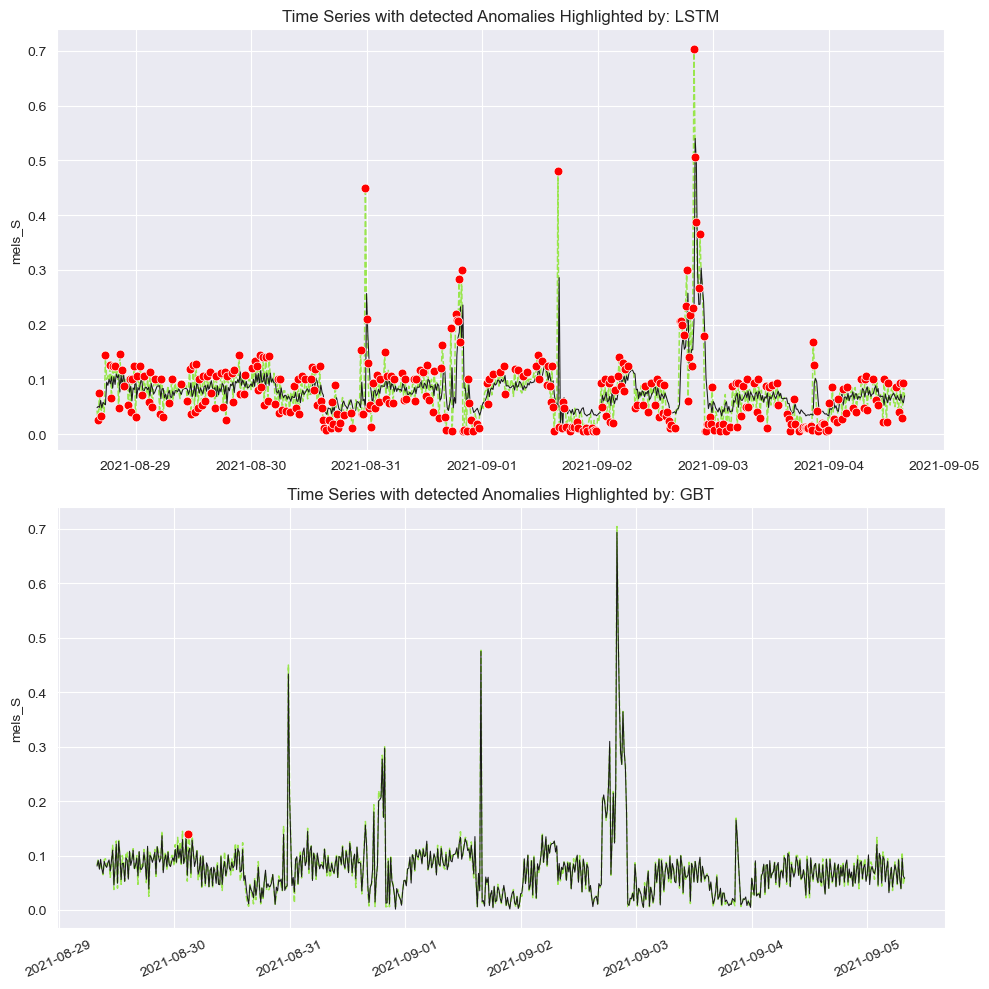

In [7]:
TSD = TimeSeriesDetect()
TSD.run("2021-08-28", "ele-2", "mels_S", 0.02)


Started Detection of ele-1_mels_S with LSMT
debugging get_date_range_index | found start date 2020-10-10 00:00:00 and end date 2020-10-16 23:45:00 in mels_S


/var/folders/km/mq2d28q535n4074lxnctcm300000gn/T/ipykernel_95044/2451088960.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_path_to_model)


Completed scan of 672 points in 1.5 secs | Anomalies Counted: 343

Started Detection of ele-1_mels_S with GBT
debugging get_date_range_index | found start date 2020-10-10 00:00:00 and end date 2020-10-16 23:45:00 in mels_S
Completed scan of 672 points in 0.7 secs | Anomalies Counted: 41


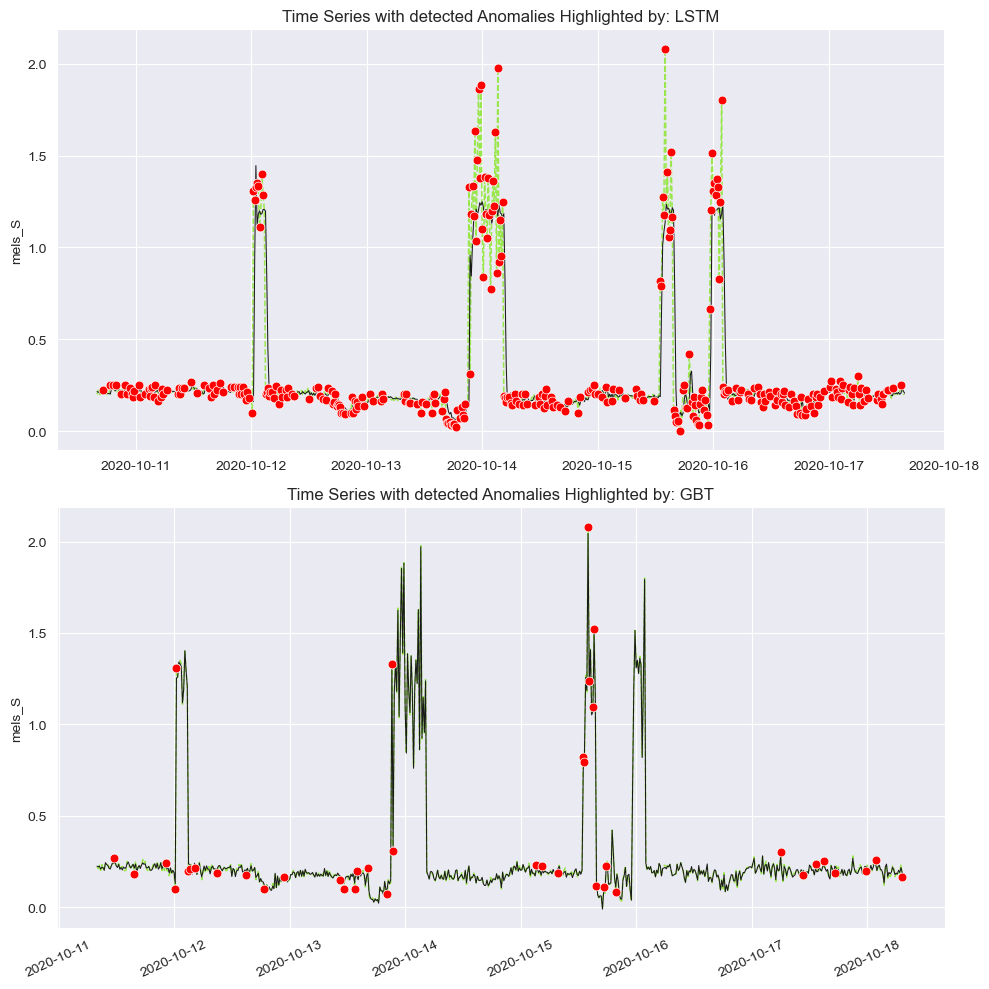

In [8]:
TSD = TimeSeriesDetect()
TSD.run("2020-10-10", "ele-1", "mels_S",0.02)


Started Detection of co2-1_zone_052_co2 with LSMT
debugging get_date_range_index | found start date 2019-11-02 00:00:00 and end date 2019-11-08 23:59:00 in zone_052_co2


/var/folders/km/mq2d28q535n4074lxnctcm300000gn/T/ipykernel_95044/2451088960.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_path_to_model)


Completed scan of 10080 points in 21.1 secs | Anomalies Counted: 159

Started Detection of co2-1_zone_052_co2 with GBT
debugging get_date_range_index | found start date 2019-11-02 00:00:00 and end date 2019-11-08 23:59:00 in zone_052_co2
Completed scan of 10080 points in 3.2 secs | Anomalies Counted: 59


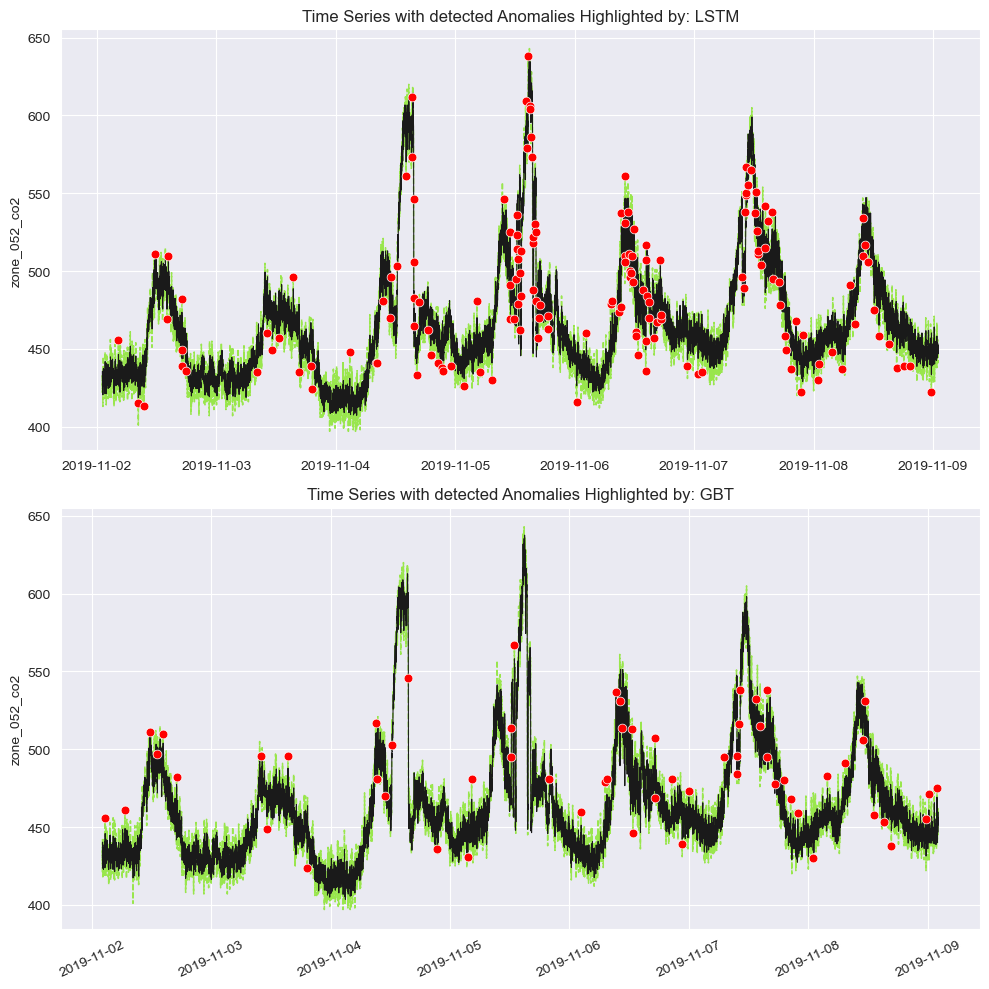

In [9]:
TSD = TimeSeriesDetect()
TSD.run("2019-11-02", "co2-1", "zone_052_co2", 22.0)


Started Detection of co2-2_zone_072_co2 with LSMT
debugging get_date_range_index | found start date 2020-10-02 00:00:00 and end date 2020-10-08 23:59:00 in zone_072_co2


/var/folders/km/mq2d28q535n4074lxnctcm300000gn/T/ipykernel_95044/2451088960.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_path_to_model)


Completed scan of 10080 points in 21.3 secs | Anomalies Counted: 85

Started Detection of co2-2_zone_072_co2 with GBT
debugging get_date_range_index | found start date 2020-10-02 00:00:00 and end date 2020-10-08 23:59:00 in zone_072_co2
Completed scan of 10080 points in 3.5 secs | Anomalies Counted: 27


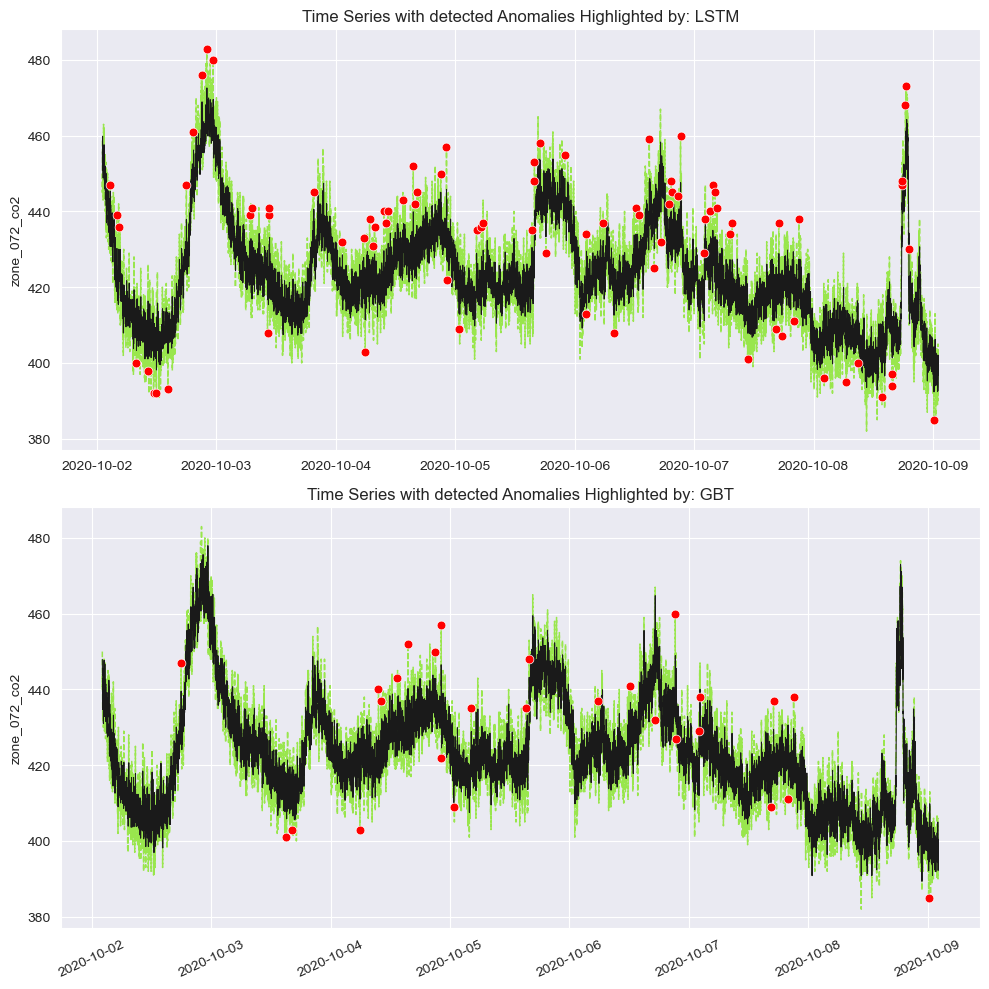

In [10]:
TSD = TimeSeriesDetect()
TSD.run("2020-10-02", "co2-2", "zone_072_co2", 15.0)